### In this notebook, we try to predict the crop yield in one year using neural network model.

# **Setup**

Mount GGdrive

Go to the project directory in my GGDrive

In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/Crop Yield Prediction"

/content/drive/MyDrive/Colab Notebooks/Crop Yield Prediction


Prepare some constants

In [ ]:
DATA_PATH = "."
MODEL_PATH = "model"

## Prepare Data

The dataset contain **temperature**, **humidity**, **Precipitaion** and **Crop Yield Area** each year from 1997 to 2014. There are 26 districts' data in a year.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from os import path # Join path

data_frame = pd.read_csv(path.join(DATA_PATH, "DATA_YEILD_QUANGNAM.csv"))
data_frame.head(10)

,State_Name,Crop_Year,Area,Yield,Temperature,Precipitaion,Humidity,Soil_type:_datDaVoi,Soil_type:_datSet,Soil_type:_datSetKho,Soil_type:_datCat,Soil_type:_datPhuSa,District:_BACTRAMY,District:_DUYXUYEN,District:_DAILOC,District:_DONGGIANG,District:_DIENBAN,District:_DIENBAN1,District:_HIEPDUC,District:_NAMGIANG,District:_NAMTRAMY,District:_PHUNINH,District:_NUITHANH,District:_PHUOCSON,District:_QUESON,District:_TAYGIANG,District:_TIENPHUOC,District:_THANGBINH,District:_HOIAN,District:_TAMKI,Crop:_Bap,Crop:_Lua,Crop:_Dau,Season:_DongXuan,Season:_HaThu
0,QUANGNAM,1997,1540.50,21.00,24.2430,282.072,84,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,QUANGNAM,1997,3520.00,59.10,23.1122,240.813,54,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,QUANGNAM,1997,4300.00,70.30,23.6540,230.435,44,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,QUANGNAM,1997,5700.00,72.00,24.6130,202.200,55,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,QUANGNAM,1997,1324.00,60.00,24.5384,174.092,32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
5,QUANGNAM,1997,845.00,21.00,24.0046,165.782,43,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,QUANGNAM,1997,1509.69,20.58,23.8741,140.613,38,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
7,QUANGNAM,1997,3496.00,62.00,22.3124,131.007,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8,QUANGNAM,1997,6623.00,56.10,24.7984,88.113,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
9,QUANGNAM,1997,15500.00,56.00,24.6920,49.673,74,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


### **Show data**

Use `matplotlib` to visualize data.

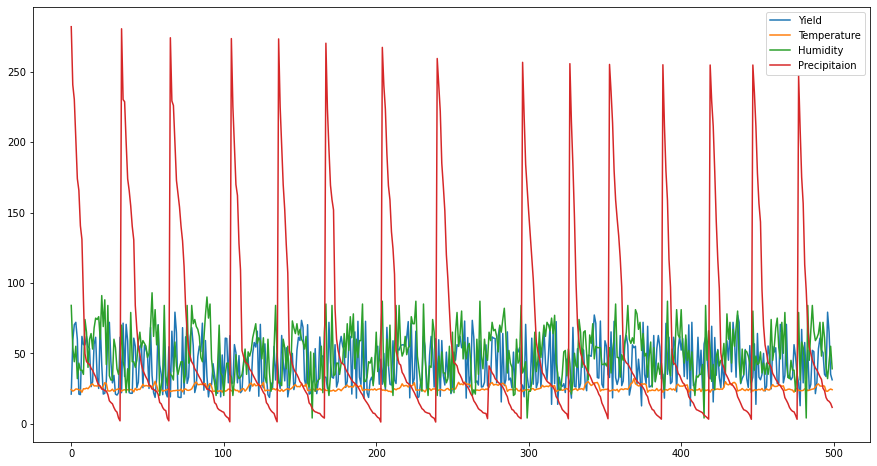

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

plot_cols = ["Yield", "Temperature", "Humidity", "Precipitaion"]
plot_features = data_frame[plot_cols][0 : 500]
plot_features.plot(subplots = False)

### **Preprocess data**

In [ ]:
X_frame = pd.DataFrame(data_frame).drop(columns=["Yield", "State_Name", "Crop_Year"]);

X_frame1 = pd.DataFrame(X_frame).get(["Area", "Temperature", "Humidity", "Precipitaion"]);

X_frame2 = pd.DataFrame(X_frame).drop(columns=["Area", "Temperature", "Humidity", "Precipitaion"]);

Y_frame = pd.DataFrame(data_frame).get(["Yield"])

We using `MinMaxScaller` from `sklearn` library to normalize data in range 0 to 100.

In [ ]:
SCALER_MIN = 0.0
SCALER_MAX = 10.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X1 = MinMaxScaler(feature_range=(SCALER_MIN, SCALER_MAX))
X_1 = scaler_X1.fit_transform(X_frame1)

scaler_Y = MinMaxScaler(feature_range=(SCALER_MIN, SCALER_MAX))
Y = scaler_Y.fit_transform(Y_frame)

In [ ]:
X_frame1 = pd.DataFrame(data=X_1, columns=X_frame1.columns)
Y_frame = pd.DataFrame(data=Y, columns=Y_frame.columns)

In [ ]:
print(X_frame1.head(3))
print(X_frame2.head(3))
print(Y_frame.head(3))

       Area  Temperature  Humidity  Precipitaion
0  0.498858     1.992857  8.988764     10.000000
1  1.252379     0.825591  5.617978      8.531336
2  1.549296     1.384863  4.494382      8.161919
   Soil_type:_datDaVoi  Soil_type:_datSet  ...  Season:_DongXuan  Season:_HaThu
0                    0                  1  ...                 0              1
1                    0                  0  ...                 0              1
2                    0                  0  ...                 0              1

[3 rows x 28 columns]
      Yield
0  1.257915
1  6.980826
2  8.663152


Save `scaler`

In [ ]:
SCALER_PATH = "scalers"

In [ ]:
from os import path
from sklearn.externals import joblib

joblib.dump(scaler_X1, path.join(SCALER_PATH, "scalerX1.save"))
joblib.dump(scaler_Y, path.join(SCALER_PATH, "scalerY.save"))

['scalers/scalerY.save']

In [ ]:
scaler_X1_json = {
    "min": scaler_X1.feature_range[0],
    "max": scaler_X1.feature_range[1],
    "data_min": scaler_X1.data_min_.tolist(),
    "data_max": scaler_X1.data_max_.tolist()
}

scaler_Y_json = {
    "min": scaler_Y.feature_range[0],
    "max": scaler_Y.feature_range[1],
    "data_min": scaler_Y.data_min_.tolist(),
    "data_max": scaler_Y.data_max_.tolist()
}

Save `scalers` as JSON format.

In [ ]:
import json

with open(path.join(SCALER_PATH, "scalerX1.json"), 'w', encoding='utf-8') as scaler_file:
  json.dump(scaler_X1_json, scaler_file, ensure_ascii=False, indent=2)

with open(path.join(SCALER_PATH, "scalerY.json"), 'w', encoding='utf-8') as scaler_file:
  json.dump(scaler_Y_json, scaler_file, ensure_ascii=False, indent=2)

### **Split data**

We split the data into train and test dataset. The train dataset contain 80% the original data and the test data is the remaining.

In [ ]:
TRAIN_LENGTH = int(len(X_frame1.values) * 0.8)

In [ ]:
X_train_frame1 = X_frame1[0 : TRAIN_LENGTH]
X_train_frame2 = X_frame2[0 : TRAIN_LENGTH]

Y_train_frame = Y_frame[0 : TRAIN_LENGTH]

X_val_frame1 = X_frame1[TRAIN_LENGTH : ]
X_val_frame2 = X_frame2[TRAIN_LENGTH : ]

Y_val_frame = Y_frame[TRAIN_LENGTH : ]

In [ ]:
print(X_train_frame1.shape)
print(X_train_frame2.shape)
print(Y_train_frame.shape)

(454, 4)
(454, 28)
(454, 1)


# **Build Model**

The Crop Yield Model have **2 small model** below.

We using normal Neural Network to build this model.

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, concatenate, Embedding, LSTM, BatchNormalization

**The first small model** accept `area`, `temperature`, `humidity` and `precipitation` as the input. 

In that model, we use **Fully Connected Network** to take spectific property of this data. 

In [ ]:
model1 = Sequential();
model1.add(Dense(128, activation="relu", input_shape=(4,)))
model1.add(BatchNormalization())
model1.add(Dense(64, activation="relu"))
model1.add(BatchNormalization())
model1.add(Dense(3, activation="relu"))
model1.add(BatchNormalization())

model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 195       
_________________________________________________________________
batch_normalization_7 (Batch (None, 3)                 12        
Total params: 9,871
Trainable params: 9,481
Non-trainable params: 390
__________________________________________________

**The second small model** accept `soil type`, `district`, `plant` and `season` as a **one-hot vector** as the input. 

We made **1 Embedding Layer** to make a dictionary between these input types. 

Then the input is flowing throwing =**LSTM Network** to store the history of the data. 

After that, we put the **Fully Connected Network** in the rest to make prediction. 

In [ ]:
model2 = Sequential();
model2.add(Embedding(540, 64, input_length=28)) # 5 Soil types, 18 Districs, 3 Crops, 2 Seasons => 540 cases, 28 inputs
model2.add(LSTM(128))
model2.add(Dense(64, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dense(7, activation="relu"))
model2.add(BatchNormalization())

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 64)            34560     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 455       
_________________________________________________________________
batch_normalization_9 (Batch (None, 7)                 28        
Total params: 142,371
Trainable params: 142,229
Non-trainable params: 142
______________________________________________

We combine all 2 models above to **one main model**.

This model contain the normal **Fully Connected Layers** to predict the average rain fall in next 5 days.

In [ ]:
merged_model = concatenate([model1.output, model2.output])

model_output = Dense(16, activation="relu")(merged_model)
model_output = BatchNormalization()(model_output)
model_output = Dense(64, activation="relu")(model_output)
model_output = BatchNormalization()(model_output)
model_output = Dense(32, activation="relu")(model_output)
model_output = BatchNormalization()(model_output)
model_output = Dense(1, activation="relu")(model_output)

model = Model(inputs=[model1.input, model2.input], outputs=[model_output])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_16_input (InputLayer)     [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding_4_input (InputLayer)  [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 128)          640         dense_16_input[0][0]             
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 28, 64)       34560       embedding_4_input[0][0]          
____________________________________________________________________________________________

Here is the models structure.

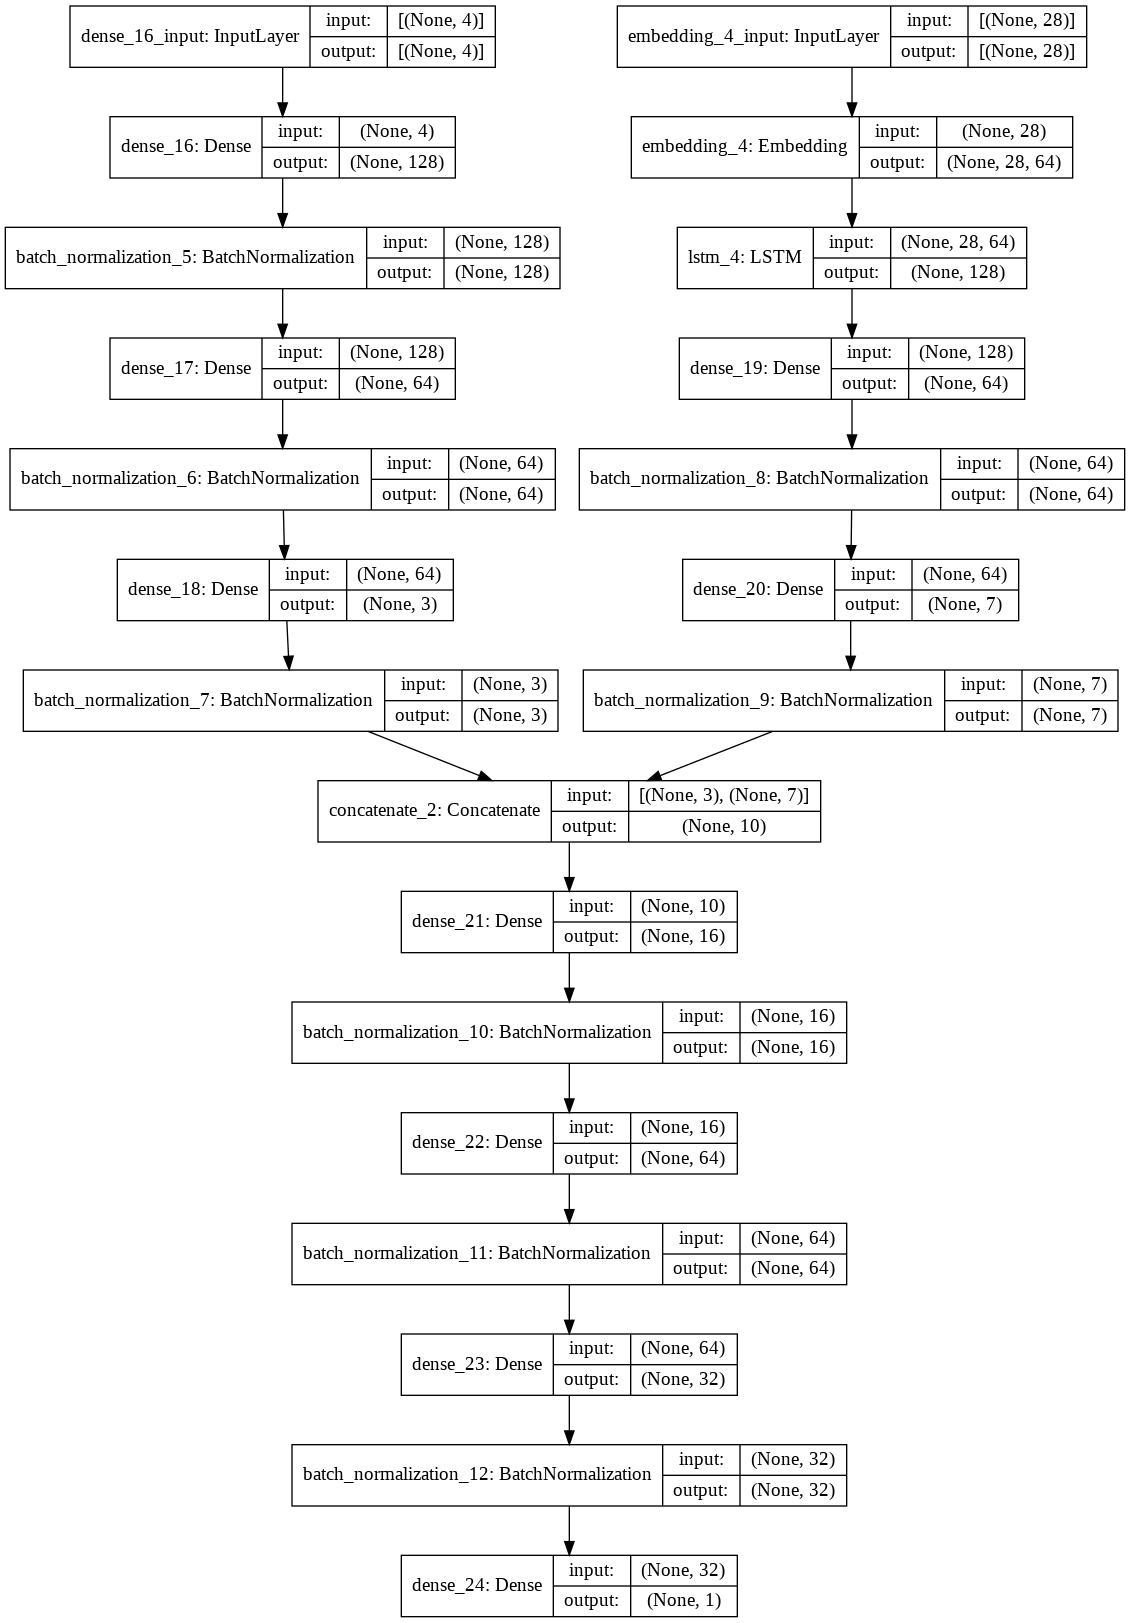

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.input_shape

[(None, 4), (None, 28)]

We compile the model with the **SGD optimizer function** with learing rate is 0.01 and using **MSE loss function** to compute the accuracy.

In [ ]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.9);

model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mse"])

# **Train model**

In each training circle, we split the data into many batchs. **Each batch contain 32 samples**.

The model is training in **100 epochs**

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
VERBOSE = 1

H = model.fit([X_train_frame1, X_train_frame2], Y_train_frame, validation_data=([X_val_frame1, X_val_frame2], Y_val_frame), epochs=EPOCHS, verbose=VERBOSE)

Epoch 1/100
15/15 [==============================] - 5s 84ms/step - loss: 14.1697 - mse: 14.1697 - val_loss: 19.0004 - val_mse: 19.0004
Epoch 2/100
15/15 [==============================] - 1s 40ms/step - loss: 8.4697 - mse: 8.4697 - val_loss: 24.6305 - val_mse: 24.6305
Epoch 3/100
15/15 [==============================] - 1s 41ms/step - loss: 6.3506 - mse: 6.3506 - val_loss: 22.7055 - val_mse: 22.7055
Epoch 4/100
15/15 [==============================] - 1s 39ms/step - loss: 5.1361 - mse: 5.1361 - val_loss: 24.0312 - val_mse: 24.0312
Epoch 5/100
15/15 [==============================] - 1s 41ms/step - loss: 5.0912 - mse: 5.0912 - val_loss: 19.0960 - val_mse: 19.0960
Epoch 6/100
15/15 [==============================] - 1s 41ms/step - loss: 5.1881 - mse: 5.1881 - val_loss: 33.7175 - val_mse: 33.7175
Epoch 7/100
15/15 [==============================] - 1s 39ms/step - loss: 4.4219 - mse: 4.4219 - val_loss: 23.0138 - val_mse: 23.0138
Epoch 8/100
15/15 [==============================] - 1s 40ms

### **Save model**

Save model into drive

In [ ]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


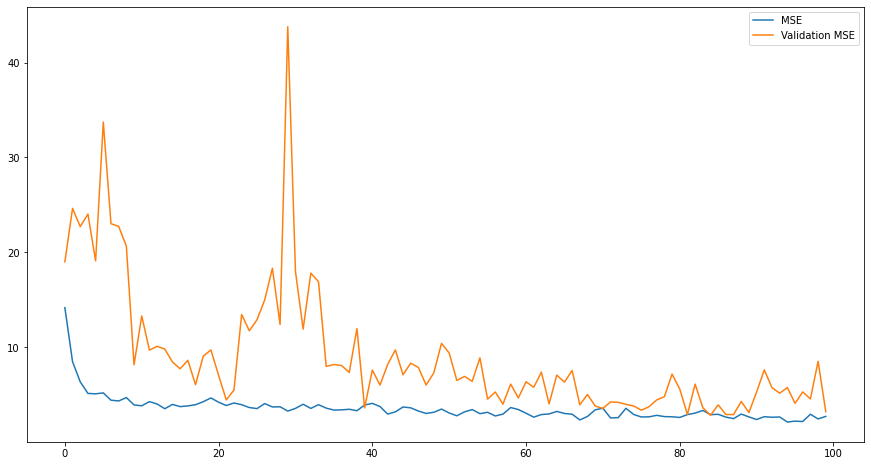

In [ ]:
import matplotlib.pyplot as plt

history = H.history

history["mse"]
plt.plot(range(len(history["mse"])), history["mse"])
plt.plot(range(len(history["val_mse"])), history["val_mse"])
plt.legend(["MSE", "Validation MSE"])
plt.show()


The result high accuracy, we can use this trained model to predict Crop Yield Havest in the app.

## **Test Model**

We test the model in the test dataset we have prepare before.

The result is shown below.

In [ ]:
model.input_shape

[(None, 4), (None, 28)]

In [ ]:
X_train_frame2.head(10)

,Soil_type:_datDaVoi,Soil_type:_datSet,Soil_type:_datSetKho,Soil_type:_datCat,Soil_type:_datPhuSa,District:_BACTRAMY,District:_DUYXUYEN,District:_DAILOC,District:_DONGGIANG,District:_DIENBAN,District:_DIENBAN1,District:_HIEPDUC,District:_NAMGIANG,District:_NAMTRAMY,District:_PHUNINH,District:_NUITHANH,District:_PHUOCSON,District:_QUESON,District:_TAYGIANG,District:_TIENPHUOC,District:_THANGBINH,District:_HOIAN,District:_TAMKI,Crop:_Bap,Crop:_Lua,Crop:_Dau,Season:_DongXuan,Season:_HaThu
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
5,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


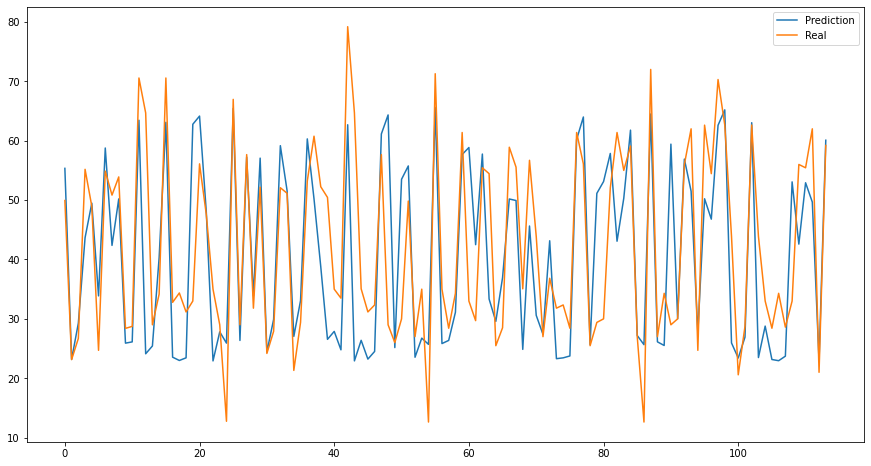

In [ ]:
prediction = model.predict([X_val_frame1, X_val_frame2])

prediction_yield = scaler_Y.inverse_transform(prediction)
Y_val_real = scaler_Y.inverse_transform(Y_val_frame)

test_frame = pd.DataFrame()

test_frame["Prediction"] = np.reshape(prediction_yield, (len(prediction_yield), ))
test_frame["Real"] = np.reshape(Y_val_real, (len(Y_val_real), ))

test_frame[0:150].plot()

### **Test in one real data point**

In [ ]:
import numpy as np

prediction = model.predict([
      scaler_X1.transform([[1540.5, 23.111, 54, 14.398]]),
      np.array([[
                 0, 1, 0, 0, 0,
                 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 0, 1, 0, 0,
                 0, 1
      ]])
])

print("Real: 21")
print(scaler_Y.inverse_transform(prediction))

Real: 21
[[22.212559]]


# **Convert to tflite**

To use this model in edge devices such as android devices. We have to convert the model into `tensorflow lite` format.

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('crop_yield_prediction_model.tflite', 'wb') as f:
  f.write(tflite_model)